In [80]:
import ast
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

audio_df = pd.read_csv(
    '../audio_classification_3sec_deep_32.csv',
    converters={2: ast.literal_eval}
)

audio_df = audio_df.set_axis(['clip_id', 'genre', 'features', 'isAugmented'], axis=1)

records = []
for _, row in audio_df.iterrows():
    clip = row['clip_id']
    is_aug = row['isAugmented']
    genre  = row['genre']
    for seg_id, feat_vec in enumerate(row['features']):
        rec = {
            'clip_id':     clip,
            'isAugmented': is_aug,
            'segment_id':  seg_id,
            'genre':       genre
        }
        for i, v in enumerate(feat_vec):
            rec[f'feat_{i}'] = v
        records.append(rec)

seg_df = pd.DataFrame(records)
le = LabelEncoder()
seg_df['genre_idx'] = le.fit_transform(seg_df['genre'])

real_clips = audio_df[audio_df.isAugmented == 0]

train_clips_old, test_clips = train_test_split(
    real_clips, test_size=0.2, random_state=42,
    stratify=real_clips['genre'], shuffle=True
)

train_clips, valid_clips = train_test_split(train_clips_old, test_size=0.1, random_state=42, stratify=train_clips_old['genre'])

train_ids = train_clips['clip_id'].tolist()
test_ids = test_clips['clip_id'].tolist()
valid_ids = valid_clips['clip_id'].tolist()

train_ids_full = []
valid_ids_full = []

for id in train_ids:
    train_ids_full.append(id)
    train_ids_full.append(id+1)
    train_ids_full.append(id+2)
    
for id in valid_ids:
    valid_ids_full.append(id)

train_df = seg_df[seg_df.clip_id.isin(train_ids_full)] # real + augmented
valid_df = seg_df[seg_df.clip_id.isin(valid_ids_full)] # real + augmented
test_df  = seg_df[seg_df.clip_id.isin(test_ids)] # only real

feature_cols = [c for c in seg_df.columns if c.startswith('feat_')] + ['isAugmented']
X_train = train_df[feature_cols]
y_train = train_df['genre_idx']

X_valid = valid_df[feature_cols]
y_valid = valid_df['genre_idx']

X_test  = test_df[feature_cols]
y_test_segments = test_df['genre_idx']

scaler = MaxAbsScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

In [87]:
# 6) TRAIN XGBoost
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=5000,
    learning_rate=0.075,
    max_depth=5,
    booster="gbtree",
    random_state=1122,
    eval_metric='mlogloss',
    device='cuda',
    n_jobs=-1,
    early_stopping_rounds=20
)
clf.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_valid_scaled, y_valid)], verbose=True)

[0]	validation_0-mlogloss:2.16390	validation_1-mlogloss:2.17749
[1]	validation_0-mlogloss:2.05128	validation_1-mlogloss:2.07550
[2]	validation_0-mlogloss:1.95546	validation_1-mlogloss:1.98633
[3]	validation_0-mlogloss:1.87324	validation_1-mlogloss:1.91126
[4]	validation_0-mlogloss:1.79986	validation_1-mlogloss:1.84455
[5]	validation_0-mlogloss:1.73260	validation_1-mlogloss:1.77835
[6]	validation_0-mlogloss:1.67116	validation_1-mlogloss:1.72610
[7]	validation_0-mlogloss:1.61562	validation_1-mlogloss:1.67273
[8]	validation_0-mlogloss:1.56470	validation_1-mlogloss:1.62710
[9]	validation_0-mlogloss:1.51690	validation_1-mlogloss:1.58454
[10]	validation_0-mlogloss:1.47250	validation_1-mlogloss:1.54254
[11]	validation_0-mlogloss:1.43013	validation_1-mlogloss:1.50721
[12]	validation_0-mlogloss:1.39098	validation_1-mlogloss:1.47313
[13]	validation_0-mlogloss:1.35455	validation_1-mlogloss:1.44376
[14]	validation_0-mlogloss:1.31991	validation_1-mlogloss:1.41439
[15]	validation_0-mlogloss:1.28715	

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.075, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5000, n_jobs=-1,
              num_parallel_tree=None, ...)

In [88]:
test_df = test_df.assign(pred_seg=clf.predict(X_test_scaled))

clip_preds = {
    cid: Counter(grp['pred_seg']).most_common(1)[0][0]
    for cid, grp in test_df.groupby('clip_id')
}

clip_summary = (
    test_df
    .groupby('clip_id')
    .agg(
       true = ('genre_idx', 'first'),
       pred = ('pred_seg', lambda x: Counter(x).most_common(1)[0][0])
    )
)

from sklearn.metrics import accuracy_score
print("file-level acc:", accuracy_score(clip_summary['true'], clip_summary['pred']))

y_true = test_df['genre_idx'].tolist()
print("clip-level acc:", accuracy_score(test_df['pred_seg'], y_true))

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Multiclass Confusion Matrix')
    plt.show()

file-level acc: 0.83
clip-level acc: 0.767


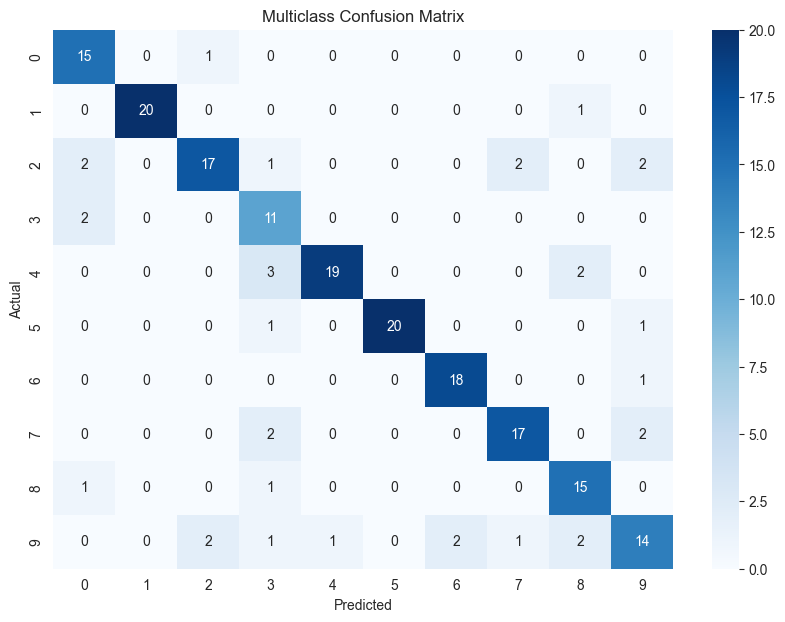

In [89]:
plot_confusion_matrix(clip_summary['pred'], clip_summary['true'], labels=y_test_segments.unique())

In [90]:
print(classification_report(y_true=clip_summary['true'], y_pred=clip_summary['pred']))

              precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.95      1.00      0.98        20
           2       0.71      0.85      0.77        20
           3       0.85      0.55      0.67        20
           4       0.79      0.95      0.86        20
           5       0.91      1.00      0.95        20
           6       0.95      0.90      0.92        20
           7       0.81      0.85      0.83        20
           8       0.88      0.75      0.81        20
           9       0.61      0.70      0.65        20

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200


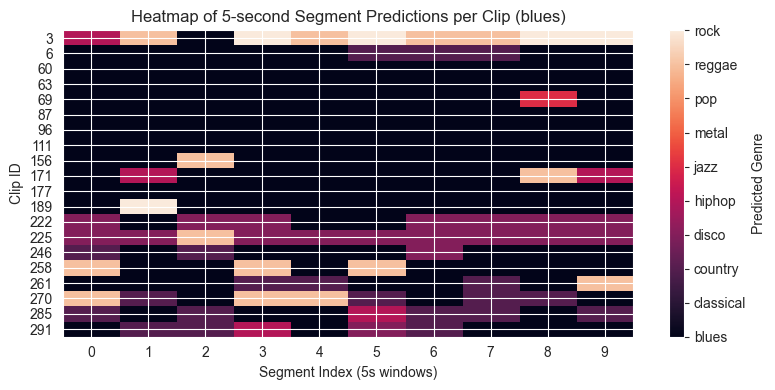

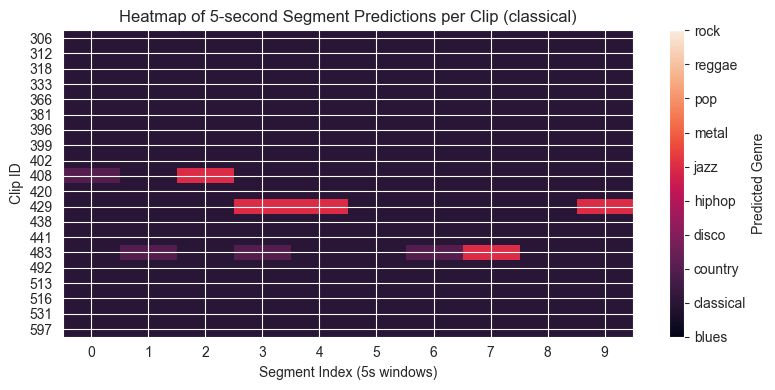

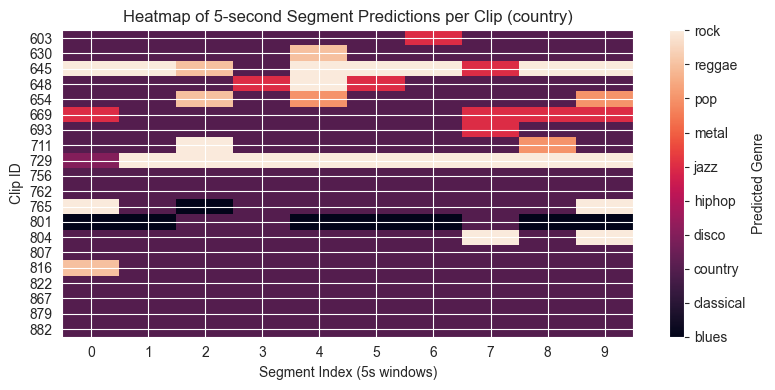

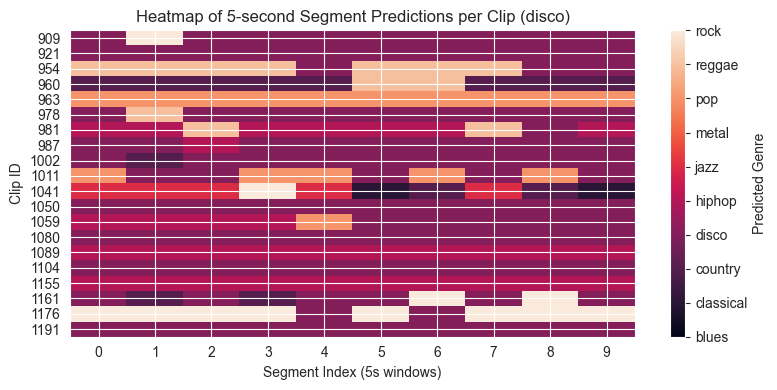

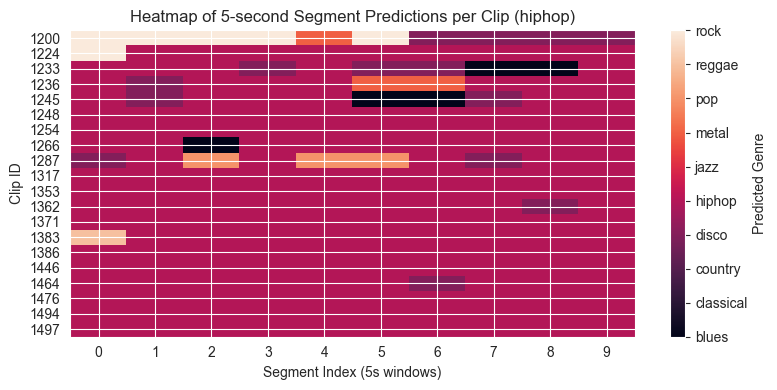

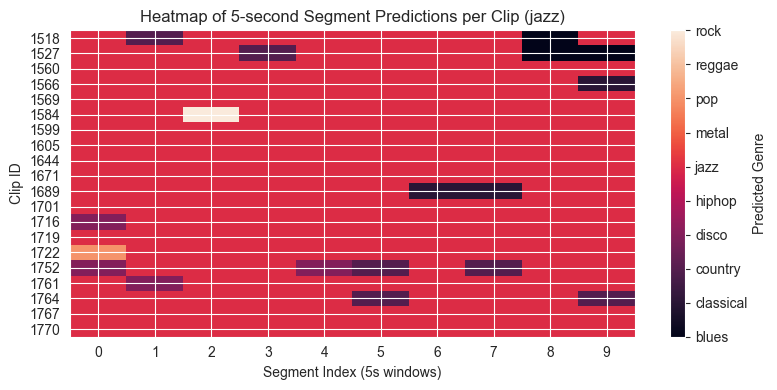

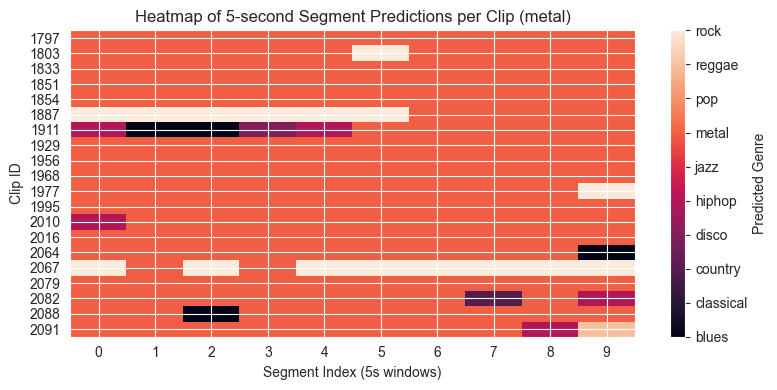

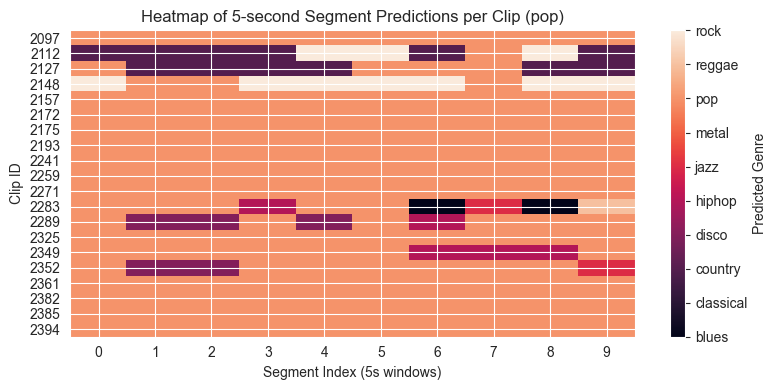

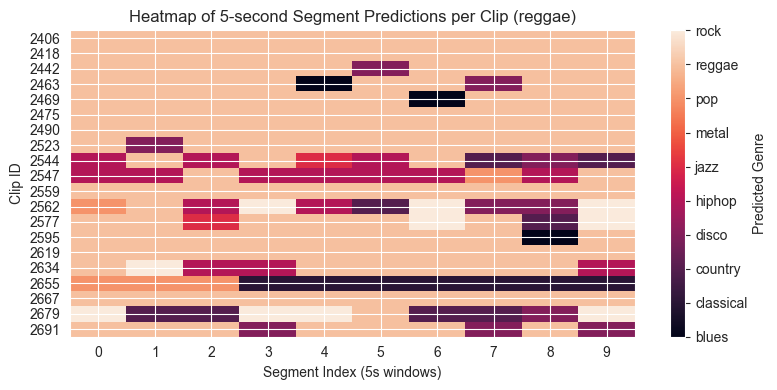

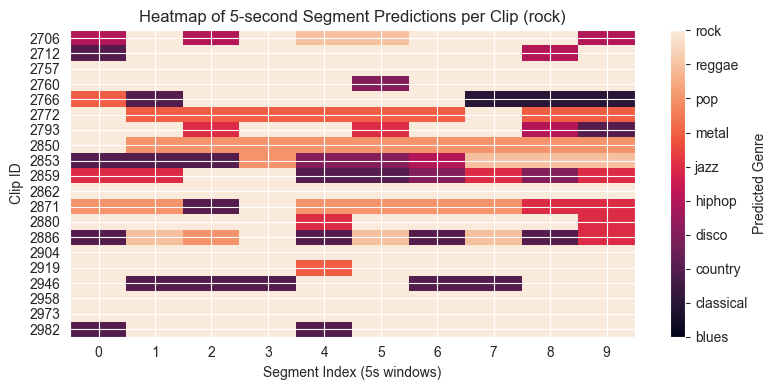

In [91]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(0, 10):
    pivot = (
        test_df[test_df['genre_idx']==i]
        .pivot(index='clip_id', columns='segment_id', values='pred_seg')
        .sort_index()
        .sort_index(axis=1)
    )
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(pivot.values, aspect='auto', vmin=0, vmax=9)
    
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    
    label = le.inverse_transform([i])
    
    ax.set_xlabel('Segment Index (5s windows)')
    ax.set_ylabel('Clip ID')
    ax.set_title(f'Heatmap of 5-second Segment Predictions per Clip ({label[0]})')
    
    cbar = fig.colorbar(im, ax=ax, ticks=np.arange(10))
    cbar.ax.set_yticklabels(le.inverse_transform(np.arange(10)))
    cbar.set_label('Predicted Genre')
    
    plt.tight_layout()
    plt.show()

In [75]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow import keras

X_train_scaled = X_train_scaled.astype(np.float32)

input_shape = X_train_scaled.shape[1:]
num_classes = len(y_test_segments.unique())

model = Sequential([
    Dense(64, activation='leaky_relu', kernel_initializer="glorot_normal"),
    Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [78]:
y_train_categorical = utils.to_categorical(y_train, num_classes=10)
y_valid_categorical = utils.to_categorical(y_valid, num_classes=10)
y_test_categorical = utils.to_categorical(y_test_segments, num_classes=10)

history = model.fit(
    X_train_scaled, np.array(y_train_categorical),
    epochs=5, batch_size=64, verbose=1, validation_data=(X_valid_scaled, np.array(y_valid_categorical)),
)

test_loss, test_acc = model.evaluate(X_test_scaled, y_test_categorical, verbose=2)
print(f"Test Accuracy: {test_acc:.2%}")

y_pred = model.predict(X_test).argmax(axis=1)

Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4095 - loss: 1.7463 - val_accuracy: 0.5863 - val_loss: 1.2774
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5639 - loss: 1.2881 - val_accuracy: 0.6162 - val_loss: 1.1014
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6100 - loss: 1.1551 - val_accuracy: 0.6400 - val_loss: 1.0247
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6316 - loss: 1.0792 - val_accuracy: 0.6650 - val_loss: 0.9734
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6533 - loss: 1.0258 - val_accuracy: 0.6762 - val_loss: 0.9608
63/63 - 0s - 1ms/step - accuracy: 0.6595 - loss: 1.0471
Test Accuracy: 65.95%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       1.00      0.05      0.10       200
           2       0.00      0.00      0.00       200
           3       0.00      0.00      0.00       200
           4       0.00      0.00      0.00       200
           5       0.00      0.00      0.00       200
           6       0.00      0.00      0.00       200
           7       0.10      1.00      0.18       200
           8       0.00      0.00      0.00       200
           9       0.00      0.00      0.00       200

    accuracy                           0.10      2000
   macro avg       0.11      0.11      0.03      2000
weighted avg       0.11      0.10      0.03      2000


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

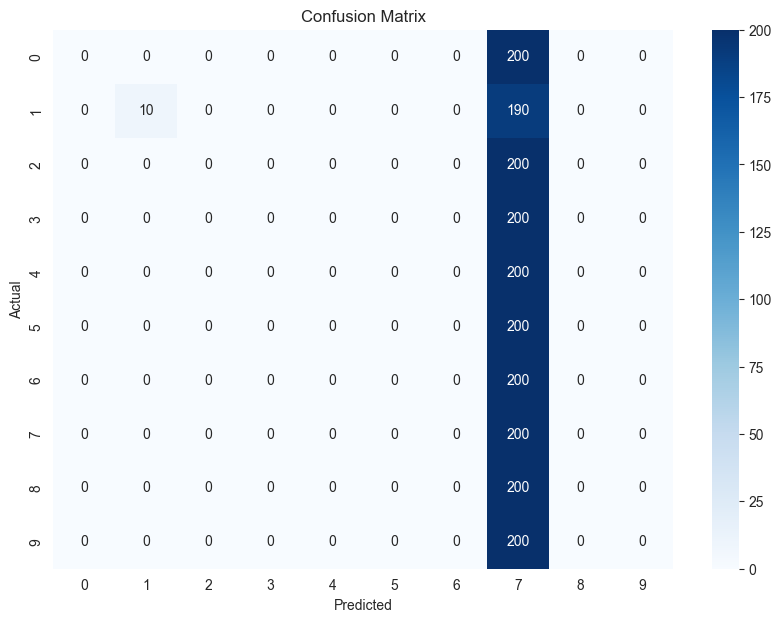

In [79]:
print(classification_report(y_test_segments, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_segments, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y_test_segments.unique(), yticklabels=y_test_segments.unique(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()